## Planning Architecture

### Non-deterministic Filter
At time step $t$, given estimates of bounding boxes of obstacles, we have:
$\hat{\mathcal X_t}$ = estimate of the occupied space in the environment.

With estimate from the previous time step, update the estimate as: 
$\bar{\mathcal X_t}=\bar{\mathcal X}_{t-1}\cap\hat{\mathcal X_t}$

### Planning
Plan path to goal for time step $t$, ensuring that we do not enter the ICS at time step $t+1$.
- Simple planning (FMT*) if there is a collision free path to goal
- Optimistic plan if there is no collision free path to goal (?)
    - Replan at next time step
        - Brake if no more plan

- Choice of U: all unobserved space is free space (implemented in our filter)
- Choice of ICS: figure out on Go1
- Choice of intermediate goal: implement or just long-term goal -> no need to use
- Choice of solver: FMT*

In [2]:
A1x = 0.1;A1y = 0.1;A1z = 0.1;A2x=0.2;A2y=0.2;A2z=0.2
B1x = 0.3;B1y = 0.3;B1z = 0.3;B2x=0.4;B2y=0.8;B2z=0.8
C1x = 0.35;C1y = 0.6;C1z = 0.6;C2x=0.45;C2y=0.7;C2z=0.7
D1x = 0.15;D1y = 0.15;D1z = 0.4;D2x=0.7;D2y=0.5;D2z=0.5
A = np.array([[A1x,A1y],[A2x,A2y]])
B = np.array([[B1x,B1y],[B2x,B2y]])
C = np.array([[C1x,C1y],[C2x,C2y]])
D = np.array([[D1x,D1y],[D2x,D2y]])

occ_space = box_to_occ_space(A,B,C,D)

xbar_prev = box_to_occ_space(A, B)
xhat_now = box_to_occ_space(C, D)
xbar_now = non_det_filter(xbar_prev, xhat_now)

map_design = occ_to_map(xbar_now,1,1,0.01) # convert to map
# map_design is image format, 1 = free, 0 = obstacle

NameError: name 'np' is not defined

## Safety Planner
- ICS includes left turn and right turn
- Plans for intermediate goal

In [1]:
import numpy as np
xbar_now = np.array([[[0.15, 0.15],[0.2 , 0.2 ]],
                     [[0.35, 0.6 ],[0.4 , 0.7 ]],
                     [[0.3 , 0.3 ],[0.4 , 0.5 ]]])
# import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle
# plt.rcParams['figure.figsize'] = [4,3]
# from plan_func import *

In [2]:
from safety_planner import Safety_Planner
safe_planner = Safety_Planner(xbar_now,[0.45,0.1,np.pi/2],[1,1,np.pi/2])
safe_planner.plan()

Reached goal
Reached goal
Reached goal
Reached goal
Reached goal
Reached goal
Reached goal
Reached goal
Reached goal
Reached goal
Reached goal
Reached goal
Reached goal
Reached goal
Reached goal
Reached goal
Reached goal
Reached goal
Reached goal


{'path': array([[0.45      , 0.1       , 1.57079633],
        [0.45055276, 0.16917499, 0.51138909],
        [0.58416978, 0.25785055, 1.1542484 ],
        [0.66213203, 0.31213203, 1.57079633]]),
 'n_steps': 36,
 'cost': 0.3245398343365964,
 'goal_flag': 1}

In [3]:
safe_planner.subgoal

array([0.66213203, 0.31213203])

In [3]:

from plan_func import *
map_design = occ_to_map(xbar_now,safe_planner.w,safe_planner.h,safe_planner.dx) # convert to map
planner = FMTPlanner(map_design)
planner_dynamic = FMTPlanner_dynamics(map_design)

In [8]:
planner_dynamic.plan([0.25,0.1,1.57],[0.6,0.8, 1.57])

Reached goal


{'path': array([[0.25      , 0.1       , 1.57      ],
        [0.25      , 0.1       , 0.7       ],
        [0.30372182, 0.20827787, 0.9612305 ],
        [0.36442534, 0.25518162, 0.61092685],
        [0.44618474, 0.34519725, 0.66541138],
        [0.45610057, 0.45057201, 0.98243575],
        [0.47053519, 0.51735949, 0.91440496],
        [0.54286776, 0.65390151, 0.95330382],
        [0.6       , 0.8       , 1.57      ]]),
 'n_steps': 67,
 'cost': 0.804748498583836,
 'goal_flag': 1}

In [13]:
goal_inter(occ_space=xbar_now, world_box=np.array([[0,0],[1,1]]), 
           planner_dynamic=planner_dynamic, planner=planner,
           start = [0.25,0.1,1.57], goal = [0.6,0.8,1.57], radius = 0.1, FoV = 1.57)

[0.32073882691672, 0.17068251811053659, 1.57]
Search failed
2000
Reached goal
0.6884964021718232
[0.46221648075016, 0.3120475543316098, 1.57]
Search failed
2000
Reached goal
0.507032432306489
[0.6036941345836, 0.453412590552683, 1.57]
Search failed
2000
Reached goal
0.3466070960290974
[0.7451717884170399, 0.5947776267737562, 1.57]
Search failed
2000
Reached goal
0.2513783415985027
[0.8866494422504799, 0.7361426629948293, 1.57]
Search failed
2000
Reached goal
0.29367611791206855
[0.15527864045000422, 0.2894427190999916, 1.57]
Search failed
2000
Reached goal
0.6770862756842785
[0.06583592135001262, 0.4683281572999748, 1.57]
Search failed
2000
Reached goal
0.6287586772045537
[0.46, 0.38, 1.57]
Search failed
2000
Reached goal
0.4427188724235731
[0.5800000000000001, 0.54, 1.57]
Search failed
2000
Reached goal
0.260768096208106
[0.7000000000000001, 0.7, 1.57]
Search failed
2000
Reached goal
0.14142135623730964
[0.8200000000000001, 0.8600000000000001, 1.57]
Search failed
2000
Reached goal
0.2

array([0.7, 0.7])

In [14]:
def plot_frontier(occ_space, world_box, start, FoV):
    segments_dict = find_frontier(occ_space, world_box, start, FoV)
    # print(ray_angles)
    # print(segments_dict)
    candidates = find_candidates(segments_dict, 0.05)
    fig, ax = plt.subplots()
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    for i in range(occ_space.shape[0]):
        w = occ_space[i,1,0] - occ_space[i,0,0]
        h = occ_space[i,1,1] - occ_space[i,0,1]
        ax.add_patch(Rectangle(occ_space[i,0,:],w, h, edgecolor = 'k',fc=(0, 0.4470, 0.7410,0.5)))
        # plt.axis('off')
    # for angle in ray_angles:
    #     ax.plot([start[0],start[0]+np.cos(angle)],[start[1],start[1]+np.sin(angle)],'r')
    for segment in segments_dict.values():
        ax.plot([segment[0,0],segment[1,0]],[segment[0,1],segment[1,1]])
    ax.scatter(*zip(*candidates))
    plt.show()

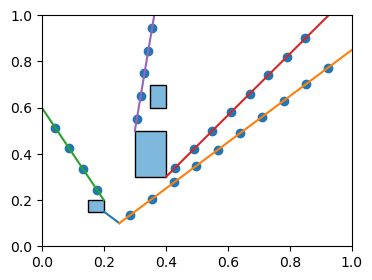

In [ ]:
plot_frontier(xbar_now, np.array([[0,0],[1,1]]), [0.25,0.1,np.pi/2], np.pi/2)

### With Dynamics

In [ ]:
def go1_dynamics_forward(state_t,u,dt):
    # state_t: [x_t, y_t, psi_t]
    state_t1 = np.zeros(3)
    state_t1[0] = state_t[0] + u[0]*np.cos(state_t[2])*dt
    state_t1[1] = state_t[1] + u[0]*np.sin(state_t[2])*dt
    state_t1[2] = state_t[2] + u[1]*dt
    return state_t1

In [ ]:
def go1_dynamics_backward(state_t,u,dt):
    state_t1 = np.zeros(3)
    state_t1[2] = state_t[2] - u[1]*dt
    state_t1[1] = state_t[1] - u[0]*np.sin(state_t1[2])*dt
    state_t1[0] = state_t[0] - u[0]*np.cos(state_t1[2])*dt
    return state_t1

In [ ]:
def visualize_result(map_design: np.ndarray, planner: FMTPlanner,
                     path_info: dict) -> None:
    plt.figure()
    plt.imshow(map_design, cmap="gray")
    nx.draw_networkx(planner.graph, [x[0:2][::-1]/planner.dx for x in planner.node_list],
            node_size=1,
            alpha=.2,
            with_labels=False)
    path = path_info["path"]
    plt.plot(path[:, 1]/planner.dx, path[:, 0]/planner.dx, 'r-', lw=2)

Reached goal


AttributeError: 'FMTPlanner' object has no attribute 'dx'

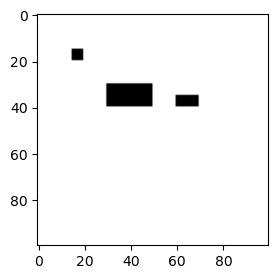

In [ ]:
visualize_result(map_design, planner, planner.plan([0.1,0.1,0.7],[0.9,0.8,0]))